# Notebook para Treinamento do Random Forest

### Instalação de Requirements

In [ ]:
! pip install -U scikit-learn
! pip install matplotlib
! pip install pyarrow
! pip install fastparquet


## Importação das Bibliotecas Necessárias

In [2]:
import pandas as pd
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

import pickle

## Carregar e Balancear o Conjunto de Dados

In [3]:
df = pd.read_parquet("../data/processed/sim_2006_2017_pre_processed.parquet")

In [4]:
suicidio_0 = df[df['SUICIDIO'] == 0]
suicidio_1 = df[df['SUICIDIO'] == 1]

suicidio_0_sample = suicidio_0.sample(n=len(suicidio_1), replace=False)
balanced_df = pd.concat([suicidio_0_sample, suicidio_1], ignore_index=True).reset_index(drop=True)
df

,ESC,ESTCIV,IDADE,NATURAL,OCUP,RACACOR,MASCULINO,FEMININO,SUICIDIO
0,-1.732328,0.809986,-0.187545,-1,0.844239,-0.484485,True,False,0
1,-0.226709,-0.329698,0.753377,-1,-1.066134,3.994021,True,False,0
2,-0.226709,0.240144,1.380658,-1,-0.337181,-0.484485,False,True,0
3,-0.226709,-0.899540,1.171564,-2,-1.066134,-0.484485,True,False,0
4,-1.732328,0.240144,0.701103,-1,-1.587212,-0.484485,False,True,0
...,...,...,...,...,...,...,...,...,...
3045770,-0.979518,-0.899540,-1.337560,35,0.844239,3.994021,False,True,0
3045771,-0.000199,3.659197,-0.082998,35,-1.587212,-0.484485,True,False,0
3045772,-0.226709,-0.899540,-0.605732,29,0.844239,1.194955,True,False,0
3045773,-0.226709,0.240144,1.067017,35,0.844239,-0.484485,True,False,0


## Preparar Dados para Treinamento
Com Idade e todos os outros atributos.

In [5]:
X = balanced_df[["ESC","ESTCIV","IDADE","NATURAL","OCUP","RACACOR","MASCULINO","FEMININO"]].values
y = balanced_df["SUICIDIO"].values

### Divisão entre teste e treino

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o Modelo Random Forest

In [7]:
modelo_rf = RandomForestClassifier(max_depth=2, random_state=0)
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

### Realizar previsões com o Modelo

In [8]:
y_pred = modelo_rf.predict(X_test)

# Avaliar o Modelo

Relatório de Classificação RF (Antes da Otimização):
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      4745
           1       0.77      0.79      0.78      4688

    accuracy                           0.78      9433
   macro avg       0.78      0.78      0.78      9433
weighted avg       0.78      0.78      0.78      9433

Matriz de Confusão:
 [[3656 1089]
 [ 991 3697]]


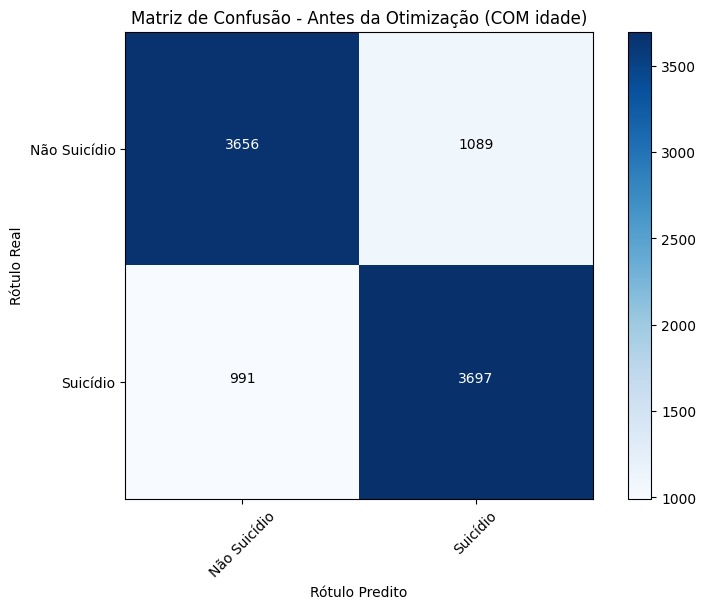

In [9]:
print("Relatório de Classificação RF (Antes da Otimização):\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Antes da Otimização (COM idade)')
plt.colorbar()
tick_marks = np.arange(len(['Não Suicídio', 'Suicídio']))
plt.xticks(tick_marks, ['Não Suicídio', 'Suicídio'], rotation=45)
plt.yticks(tick_marks, ['Não Suicídio', 'Suicídio'])
plt.tight_layout()
plt.ylabel('Rótulo Real')
plt.xlabel('Rótulo Predito')

# Adicionar os valores nas células da matriz
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

# Otimização e ajuste fino do sistema

### Defina a Grade de Parâmetros:
Aqui, usaremos o número de árvores (n_estimators) e a profundidade máxima da árvore (max_depth) como exemplos.

In [10]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

### Validação Cruzada e Grid Search

Usando a validação cruzada com Grid Search para encontrar a melhor combinação de hiperparâmetros que otimize o desempenho do modelo.

In [11]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

### Avalie o Melhor Modelo

Melhores Parâmetros: {'max_depth': 10, 'n_estimators': 200}
Relatório de Classificação RF (Depois da Otimização):
               precision    recall  f1-score   support

           0       0.80      0.77      0.79      4745
           1       0.78      0.81      0.79      4688

    accuracy                           0.79      9433
   macro avg       0.79      0.79      0.79      9433
weighted avg       0.79      0.79      0.79      9433

Matriz de Confusão:
 [[3674 1071]
 [ 910 3778]]


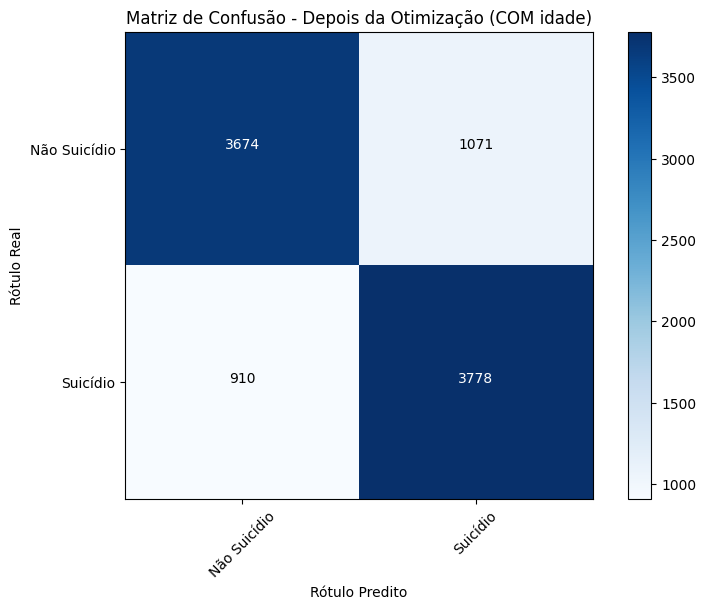

In [12]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Melhores Parâmetros:", grid_search.best_params_)
print("Relatório de Classificação RF (Depois da Otimização):\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Depois da Otimização (COM idade)')
plt.colorbar()
tick_marks = np.arange(len(['Não Suicídio', 'Suicídio']))
plt.xticks(tick_marks, ['Não Suicídio', 'Suicídio'], rotation=45)
plt.yticks(tick_marks, ['Não Suicídio', 'Suicídio'])
plt.tight_layout()
plt.ylabel('Rótulo Real')
plt.xlabel('Rótulo Predito')

# Adicionar os valores nas células da matriz
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

In [13]:
# Adicionando mais exemplos de teste ao DataFrame
teste = pd.DataFrame({
    'ESC': [5, 5, 4, 4, 3], 
    'ESTCIV': [1, 1, 2, 2, 3], 
    'IDADE': [22, 21, 34, 34, 25], 
    'NATURAL': [53, 52, 29, 29, 35], 
    'OCUP': [-1, -1, 5132, 5132, 1200], 
    'RACACOR': [4, 1, 4, 4, 2], 
    'MASCULINO': [False, True, True, True, False], 
    'FEMININO': [True, False, False, False, True]
})

std = StandardScaler()

# Padronizando os dados
columns = ['ESC', 'ESTCIV',  'OCUP', 'RACACOR']
teste[columns] = std.fit_transform(teste[columns])

# Obtendo os valores para previsão
x = teste[['ESC', 'ESTCIV', 'IDADE', 'OCUP', 'RACACOR', 'NATURAL', 'MASCULINO', 'FEMININO']].values

# Fazendo previsões
y_pred = best_model.predict(x)
y_pred

array([0, 0, 0, 0, 0], dtype=int64)

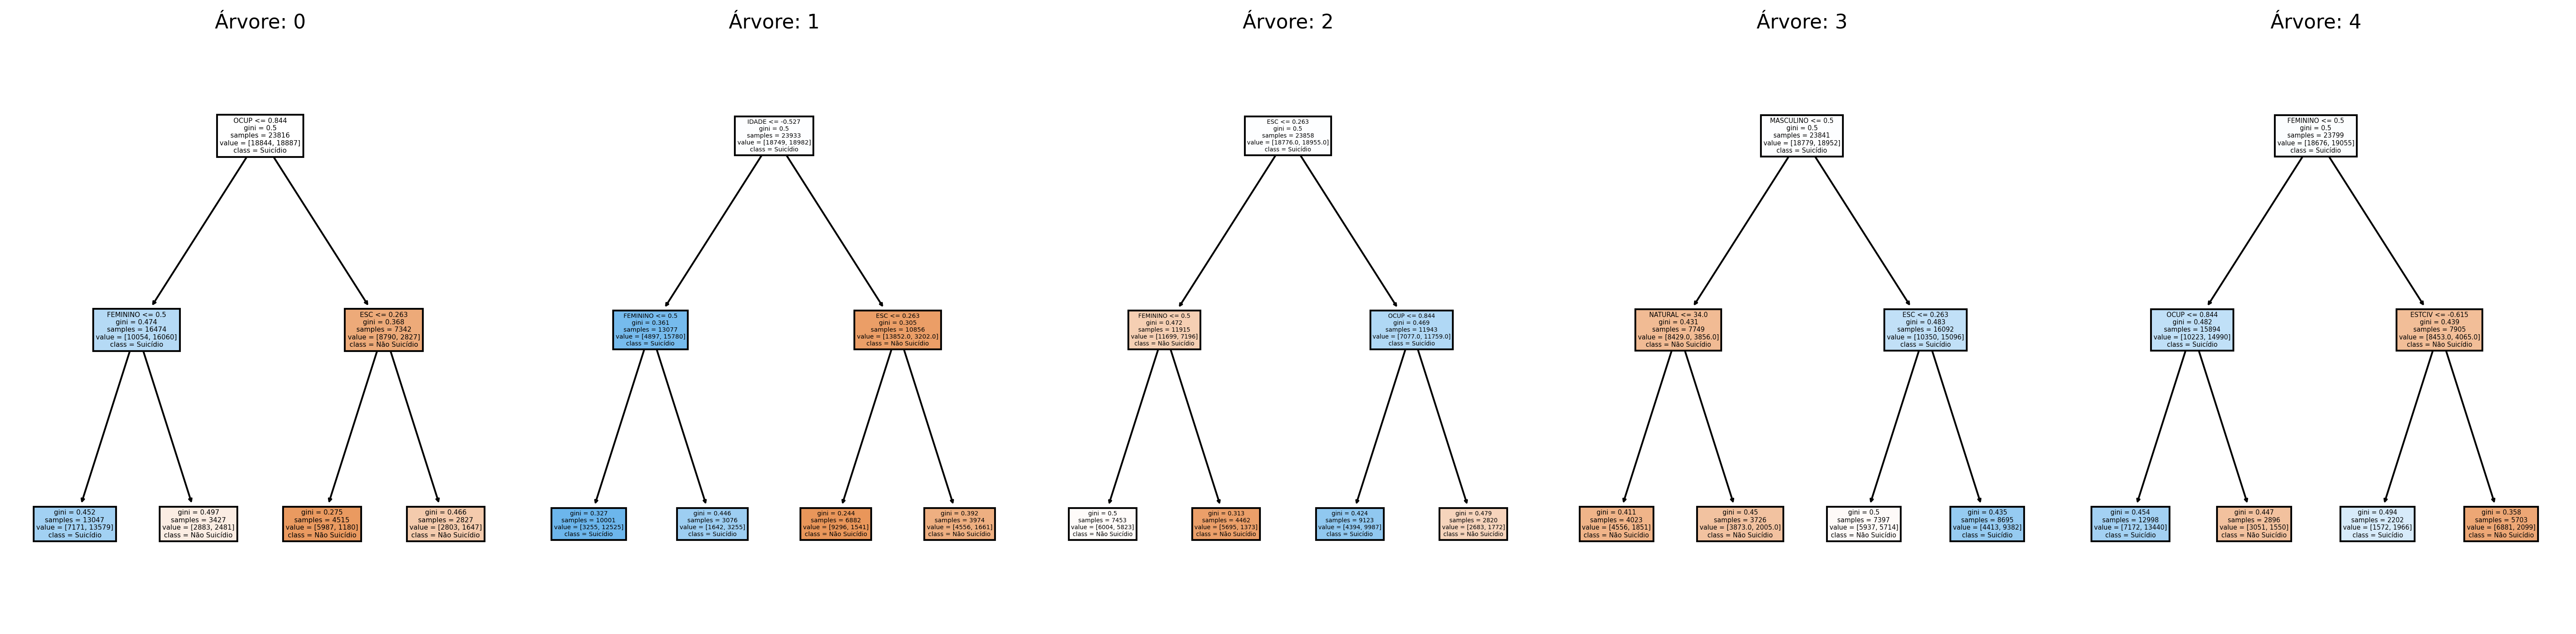

In [14]:
# Visualizar as primeiras 5 árvores do modelo Random Forest
feature_names = ["ESC", "ESTCIV", "IDADE", "NATURAL", "OCUP", "RACACOR", "MASCULINO", "FEMININO"]
class_names = ["Não Suicídio", "Suicídio"]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), dpi=300)
for index in range(0, 5):
    tree.plot_tree(modelo_rf.estimators_[index],
                   feature_names=feature_names, 
                   class_names=class_names,
                   filled=True,
                   ax=axes[index])
    axes[index].set_title('Árvore: ' + str(index), fontsize=11)

fig.tight_layout()
plt.show()

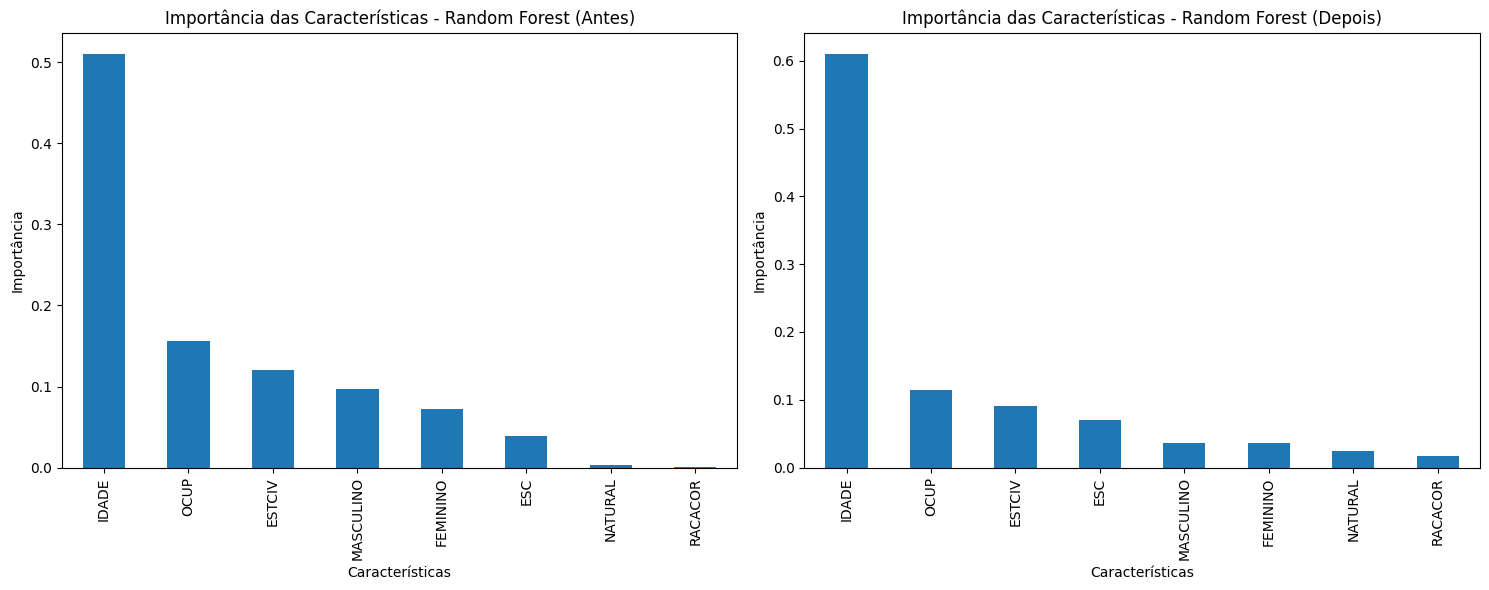

In [15]:
# Criar uma série contendo as importâncias das características do modelo inicial
feature_importances_initial = pd.Series(modelo_rf.feature_importances_, index=['ESC', 'ESTCIV', 'IDADE', 'NATURAL', 'OCUP', 'RACACOR', 'MASCULINO', 'FEMININO']).sort_values(ascending=False)

# Criar uma série contendo as importâncias das características do modelo otimizado
feature_importances_optimized = pd.Series(best_model.feature_importances_, index=['ESC', 'ESTCIV', 'IDADE', 'NATURAL', 'OCUP', 'RACACOR', 'MASCULINO', 'FEMININO']).sort_values(ascending=False)

# Plotar gráficos lado a lado
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

feature_importances_initial.plot(kind='bar', ax=axes[0])
axes[0].set_title('Importância das Características - Random Forest (Antes)')
axes[0].set_xlabel('Características')
axes[0].set_ylabel('Importância')

feature_importances_optimized.plot(kind='bar', ax=axes[1])
axes[1].set_title('Importância das Características - Random Forest (Depois)')
axes[1].set_xlabel('Características')
axes[1].set_ylabel('Importância')

plt.tight_layout()
plt.show()